In [1]:
import os
import datetime
import random
import functools
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tfsim-nightly
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


In [5]:
# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label, size=300):
    with tf.device("/cpu:0"):
        img = tf.image.resize_with_pad(img, size, size)
        img = tf.keras.applications.imagenet_utils.preprocess_input(img, mode='torch')
        return img, label

In [6]:
_, data_info = tfds.load("cars196", with_info=True)
num_examples_train = data_info.splits['train'].num_examples
num_examples_test = data_info.splits['test'].num_examples
total_num_classes = data_info.features['label'].num_classes

In [7]:
training_classes = total_num_classes // 1 
examples_per_class_per_batch = 5
train_cls = random.sample(range(total_num_classes), k=training_classes)
classes_per_batch = 80 // examples_per_class_per_batch # 16 classes per batch
origin_size = 256
target_img_size = 227

print(f"Class IDs seen during training {train_cls}")

def img_augmentation(img_batch, y, *args, target_img_size=224):
    # random resize and crop. Increase the size before we crop.
    img_batch = tf.keras.layers.RandomCrop(target_img_size, target_img_size)(img_batch)
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)
    return img_batch, y


# use the train split for training
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="train",
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(resize, size=origin_size),
    class_list=train_cls,
    augmenter=functools.partial(img_augmentation,target_img_size=target_img_size)
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="test",
    total_examples_per_class=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(resize, size=target_img_size),
)

Class IDs seen during training [148, 65, 108, 172, 155, 126, 23, 32, 84, 103, 144, 71, 13, 10, 105, 0, 80, 128, 125, 45, 44, 193, 163, 167, 38, 122, 120, 16, 82, 27, 60, 127, 56, 121, 50, 70, 22, 76, 47, 154, 6, 81, 160, 134, 130, 55, 94, 87, 162, 91, 131, 161, 9, 143, 97, 58, 109, 26, 99, 135, 7, 151, 107, 178, 164, 195, 96, 106, 20, 129, 158, 169, 159, 113, 184, 150, 15, 83, 152, 171, 36, 140, 138, 186, 69, 95, 181, 136, 73, 174, 110, 33, 187, 37, 75, 39, 168, 57, 173, 137, 89, 19, 145, 165, 42, 86, 11, 62, 98, 194, 74, 92, 8, 102, 51, 189, 101, 191, 1, 153, 88, 142, 119, 179, 52, 59, 175, 64, 30, 185, 139, 177, 54, 156, 28, 61, 146, 67, 111, 63, 85, 4, 190, 24, 21, 117, 104, 183, 14, 25, 93, 176, 41, 157, 77, 123, 48, 68, 115, 180, 66, 182, 46, 35, 34, 141, 132, 116, 188, 149, 192, 43, 2, 29, 31, 79, 170, 78, 12, 72, 49, 5, 124, 90, 18, 17, 166, 118, 100, 133, 3, 112, 147, 114, 53, 40]


converting train:   0%|          | 0/8144 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8144 [00:00<?, ?it/s]


The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8144 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/196 [00:00<?, ?it/s]

gather examples:   0%|          | 0/8144 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/8144 [00:00<?, ?it/s]

converting test:   0%|          | 0/8041 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8041 [00:00<?, ?it/s]


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8041 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/196 [00:00<?, ?it/s]

gather examples:   0%|          | 0/980 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/980 [00:00<?, ?it/s]

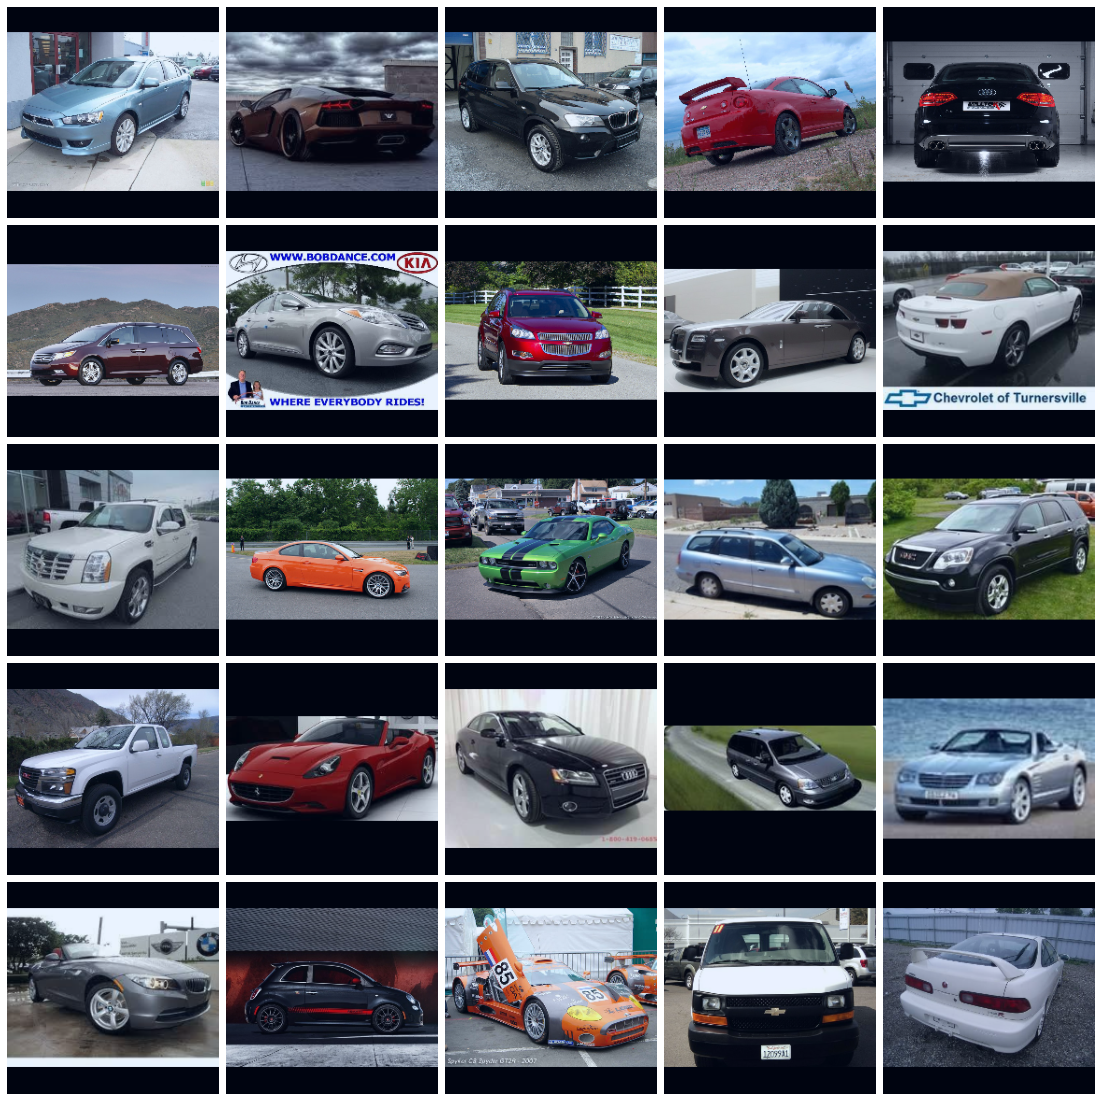

In [8]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = test_ds.get_slice(begin=0, size=num_cols * num_rows)

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(20.0, 20.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max-x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

In [9]:
num_targets = 200
num_queries = 300
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y = test_ds.get_slice(0, num_queries)
targets_x, targets_y = test_ds.get_slice(num_queries, num_targets)
# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    # known_classes=tf.constant(train_cls),
    k=k,
)

logdir = os.path.join("logs_cars", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tbc = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    val_loss,
    tbc, 
]

logs_cars/20220420-214927


In [10]:
embedding_size = 64  # @param {type:"integer"}

# building model
model = tfsim.architectures.ResNet50Sim(
    (target_img_size, target_img_size, 3), 
    embedding_size,
    trainable='partial',
    pooling="avg",    # Can change to use `gem` -> GeneralizedMeanPooling2D
    # gem_p=3.0,        # Increase the contrast between activations in the feature map.
)

In [ ]:
epochs = 500
LR = 0.00003
WD = 0.0005
steps_per_epoch = num_examples_train // (classes_per_batch * examples_per_class_per_batch)
val_steps = 50


# init similarity loss
distance = "cosine"
loss = tfsim.losses.MultiSimilarityLoss(
    distance=distance,
    alpha=2.0,
    beta=40.0,
    epsilon=0.1,
    lmda=0.5,
    center=1.0
)
optimizer = tfa.optimizers.AdamW(
    weight_decay=WD,
    learning_rate=LR
)
# optimizer = tf.keras.optimizers.Adam(LR)


# compiling and training
model.compile(
    optimizer=optimizer, 
    loss=loss
)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
)

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

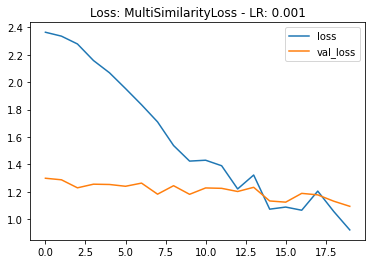

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()